# <font color = Crimson size = 6> <b>Регрессионный анализ. Нелинейная регрессия</b> </font>

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.optimize import curve_fit
from distfit import distfit

import sympy as sp

import matplotlib.pyplot as plt
import seaborn as sns

Задача состоит в том, чтобы подобрать линию (её тип), которая удачно приблизит эмпирические точки. Возможно, не наилучшим образом, но, по крайне мере, хорошо. Выбор подходящей линии и соответствующей записи уравнения регрессии называют **спецификацией модели**.

Подходящий тип линии выявляют прямым перебором основных графиков – методом наименьших квадратов строят оптимальную прямую, параболу, гиперболу, экспоненту и т.д., и анализируют, какая функция лучше приближает эмпирические точки. Качество приближения оценивают с помощью **индекса детерминации** (чем больше к единице, тем лучше) и **средней ошибки аппроксимации** (чем ближе к нулю, тем лучше).

***
## <font color = DarkGreen size = 5> <b>Экспоненциальная регрессия</b> </font>

##### <font color = SlateBlue size = 3> Пример </font>

**В результате наблюдения за размножением бактерий были получены следующие результаты:**

| X | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Y | 7 | 8 | 15 | 20 | 32 | 42 | 60 | 100 | 120 | 220 |

где, $X$ – время (часы), а $Y$ – количество бактерий.

In [2]:
df = pd.DataFrame({'X': list(range(1,11)),
                   'Y': [7, 8, 15, 20, 32, 42, 60, 100, 120, 220]})

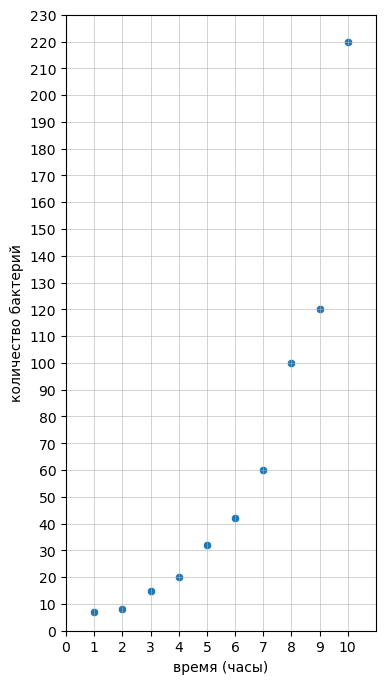

In [3]:
plt.figure(figsize=(4,8))

sns.scatterplot(x='X', y='Y', data=df)

plt.xlim([0,11])
plt.xticks(ticks=np.arange(0, 11))
plt.ylim([20,120])
plt.yticks(ticks=np.arange(0, 235, 10))
plt.xlabel('время (часы)')
plt.ylabel('количество бактерий')
plt.grid(linewidth=0.4);

In [4]:
dfit = distfit(distr=['norm', 'uniform', 'expon'])
result = dfit.fit_transform(df['Y'])
result['model']

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 9.74378e-05] [loc=62.400 scale=64.022]
[distfit] >INFO> [uniform] [0.00 sec] [RSS: 0.000121228] [loc=7.000 scale=213.000]
[distfit] >INFO> [expon  ] [0.00 sec] [RSS: 2.33252e-05] [loc=7.000 scale=55.400]
[distfit] >INFO> Compute confidence intervals [parametric]


{'name': 'expon',
 'score': 2.33252341491304e-05,
 'loc': 7.0,
 'scale': 55.4,
 'arg': (),
 'params': (7.0, 55.4),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1f329649eb0>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': 9.8416485090703,
 'CII_max_alpha': 172.96356795489103}

**Методом наименьших квадратов найдём уравнение нелинейной экспоненциальной регрессии** $y = a e^{bx}$

In [5]:
popt, pcov = curve_fit(lambda x, a, b: a * np.exp(b * x), df['X'], df['Y'])
a = popt[0]
b = popt[1]
a, b

(3.3857566245218793, 0.4133716119686246)

In [6]:
y_pred = a*np.exp(b*df['X'])
y_pred

0      5.118948
1      7.739373
2     11.701210
3     17.691138
4     26.747352
5     40.439502
6     61.140756
7     92.439123
8    139.759336
9    211.303085
Name: X, dtype: float64

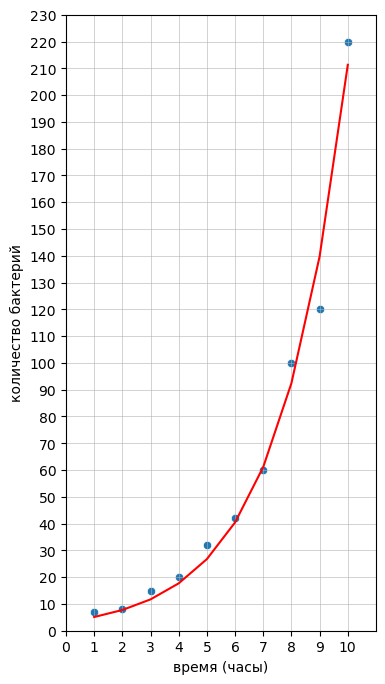

In [7]:
plt.figure(figsize=(4,8))

sns.scatterplot(x='X', y='Y', data=df)
sns.lineplot(x=df['X'], y=y_pred, color ='r')

plt.xlim([0,11])
plt.xticks(ticks=np.arange(0, 11))
plt.ylim([20,120])
plt.yticks(ticks=np.arange(0, 235, 10))
plt.xlabel('время (часы)')
plt.ylabel('количество бактерий')
plt.grid(linewidth=0.4);

In [8]:
My = df['Y'].mean()

# индекс детерминации
R2 = 1 - sum((df['Y'] - y_pred)**2) / sum((df['Y'] - My)**2)
R2

0.9859867555128073

Таким образом, в рамках построенной модели размножение бактерий (результат $Y$) на 98,6% объяснено течением времени (фактором $X$). Остальные 1,4% вариации признака-результата обусловлены другими, не учтёнными в модели факторами.

In [9]:
# индекс корреляции
R = np.sqrt(R2)
R

0.9929686578703314

Таким образом, согласно шкале Чеддока, существует практически функциональная зависимость признака-результата $Y$ от фактора $X$.

**Проверим статистическую значимость построенной модели.**

На уровне значимости $\alpha = 0.05$ \
проверим нулевую гипотезу $H_0: R_I^2 = 0$ – о том, что генеральный индекс детерминации равен нулю, \
против конкурирующей гипотезы $H_1: R_I^2 > 0$.

Для проверки гипотезы используем статистический критерий: \
$F = \cfrac{Q_R}{Q_e} \cdot \cfrac{n-m-1}{m}$, где \
$Q_R = \sum{(y(x_i)-\bar{y})^2}$ – выборочная факторная сумма квадратов, \
$Q_e = \sum(y_i - y(x_i))^2$ – выборочная остаточная сумма квадратов, \
$m$ – количество факторных (причинных) переменных.

Эта случайная величина имеет распределение Фишера (F-распределение) с количеством степеней свободы $k_1 = m$, $k_2 = n-m-1$.

Если $F_н > F_к$, то гипотезу $H_0$ на уровне значимости $\alpha$ отвергаем.\
Если $F_н < F_к$, то отвергать гипотезу $H_0$ оснований нет.

In [10]:
alpha = 0.05
m = 1
n = df.shape[0]
k1 = m
k2 = n-m-1

In [11]:
Fk = stats.f.ppf(1-alpha, k1, k2)
print(f'{Fk = }')

Fn = R2/(1-R2) * (n-m-1)/m
print(f'{Fn = }')

print(f'H0: R = 0 is {Fn<Fk}')

Fk = 5.317655071578714
Fn = 562.8884910494187
H0: R = 0 is False


Полученный результат $R_I^2 = 0.986$ статистически значим, следовательно, статистически значимо и выборочное уравнение $y = 3.385 e^{0.413 x}$ экспоненциальной регрессии.

In [12]:
# Средняя ошибка аппроксимации
A = sum(abs((df.Y-y_pred)/df.Y)) / n * 100
A

11.36776435201609

Таким образом, регрессионные значения $y(x_i)$ отличаются от соответствующих эмпирических значений $y_i$ в среднем на 11.4%, что можно признать неплохим результатом.

***
## <font color = DarkGreen size = 5> <b>Гиперболическая регрессия</b> </font>

##### <font color = SlateBlue size = 3> Пример </font>

**В результате исследования получены следующие данные:**

| X | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|---|---|---|---|---|---|---|---|---|---|---|
| Y | 70 | 30 | 20 | 25 | 17 | 15 | 12.9 | 12.9 | 11.7 | 11.7 |

где, $X$ – количество выпущенной продукции (тысяч единиц), а $Y$ – себестоимость одной единицы продукции (руб).

In [13]:
df = pd.DataFrame({'X': list(range(1,11)),
                   'Y': [70, 30, 20, 25, 17, 15, 12.9, 12.9, 11.7, 11.7]})

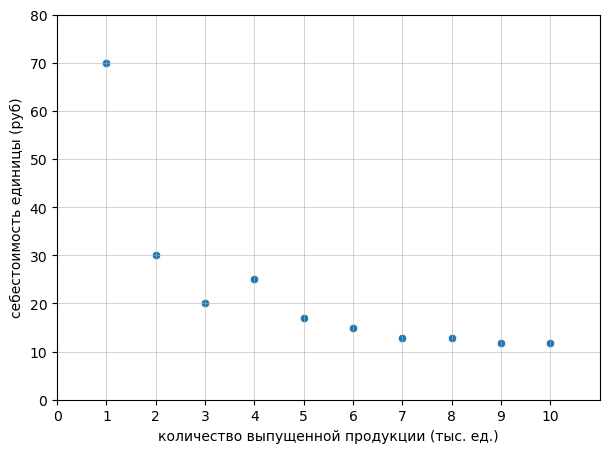

In [14]:
plt.figure(figsize=(7,5))

sns.scatterplot(x='X', y='Y', data=df)

plt.xlim([0,11])
plt.xticks(ticks=np.arange(0, 11))
plt.ylim([0,80])
plt.yticks(ticks=np.arange(0, 85, 10))
plt.xlabel('количество выпущенной продукции (тыс. ед.)')
plt.ylabel('себестоимость единицы (руб)')
plt.grid(linewidth=0.4);

Найдем уравнение $\hat{y} = a + \cfrac{b}{x}$, где \
$a, b$ – постоянные коэффициенты, \
$x$ – статистические данные аргумента функции, \
$y$ - приближение значений функции к реальным данным полученным методом наименьших квадратов

In [15]:
popt, pcov = curve_fit(lambda x, a, b: a + b / x, df['X'], df['Y'])
a = popt[0]
b = popt[1]
a, b

(4.209756380032692, 62.85572933302529)

In [16]:
y_pred = a + b / df['X']
y_pred

0    67.065486
1    35.637621
2    25.161666
3    19.923689
4    16.780902
5    14.685711
6    13.189146
7    12.066723
8    11.193726
9    10.495329
Name: X, dtype: float64

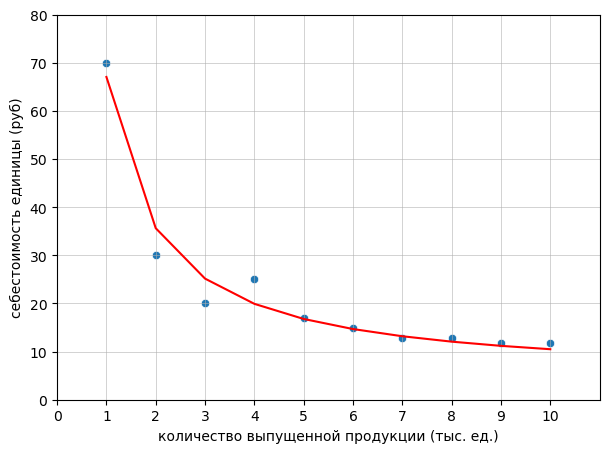

In [17]:
plt.figure(figsize=(7,5))

sns.scatterplot(x='X', y='Y', data=df)
sns.lineplot(x=df['X'], y=y_pred, color ='r')

plt.xlim([0,11])
plt.xticks(ticks=np.arange(0, 11))
plt.ylim([0,80])
plt.yticks(ticks=np.arange(0, 85, 10))
plt.xlabel('количество выпущенной продукции (тыс. ед.)')
plt.ylabel('себестоимость единицы (руб)')
plt.grid(linewidth=0.4);

In [18]:
My = df['Y'].mean()

# индекс детерминации
R2 = 1 - sum((df['Y'] - y_pred)**2) / sum((df['Y'] - My)**2)
R2

0.9662638225533281

Таким образом, в рамках построенной модели вариация себестоимости на 96,6% объяснена изменением объёма производства. Остальные 3,4% вариации обусловлены неучтёнными в модели факторами.

In [19]:
# индекс корреляции
R = np.sqrt(R2)
R

0.9829871934838867

Таким образом, себестоимость единицы продукции очень сильно зависит от объёма выпуска.

**Проверим статистическую значимость построенной модели.**

На уровне значимости $\alpha = 0.01$ \
проверим нулевую гипотезу $H_0: R_I^2 = 0$ – о том, что генеральный индекс детерминации равен нулю, \
против конкурирующей гипотезы $H_1: R_I^2 > 0$.

Для проверки гипотезы используем статистический критерий: \
$F = \cfrac{Q_R}{Q_e} \cdot \cfrac{n-m-1}{m}$, где \
$Q_R = \sum{(y(x_i)-\bar{y})^2}$ – выборочная факторная сумма квадратов, \
$Q_e = \sum(y_i - y(x_i))^2$ – выборочная остаточная сумма квадратов, \
$m$ – количество факторных (причинных) переменных.

Эта случайная величина имеет распределение Фишера (F-распределение) с количеством степеней свободы $k_1 = m$, $k_2 = n-m-1$.

Если $F_н > F_к$, то гипотезу $H_0$ на уровне значимости $\alpha$ отвергаем.\
Если $F_н < F_к$, то отвергать гипотезу $H_0$ оснований нет.

In [20]:
alpha = 0.01
m = 1
n = df.shape[0]
k1 = m
k2 = n-m-1

In [21]:
Fk = stats.f.ppf(1-alpha, k1, k2)
print(f'{Fk = }')

Fn = R2/(1-R2) * (n-m-1)/m
print(f'{Fn = }')

print(f'H0: R = 0 is {Fn<Fk}')

Fk = 11.258624143272643
Fn = 229.1341570231516
H0: R = 0 is False


Полученный результат $R_I^2 = 0.966$ статистически значим, следовательно, статистически значимо и выборочное уравнение гиперболической регрессии:
$y = 4.21 + \cfrac{62.86}{x}$

In [22]:
# Средняя ошибка аппроксимации
A = sum(abs((df.Y-y_pred)/df.Y)) / n * 100
A

9.580629333466364

Таким образом, разница между эмпирическими $y_i$ и соответствующими регрессионными $y(x_i)$ значениями составляет в среднем 9.58%, что можно признать хорошим результатом.

***
## <font color = DarkGreen size = 5> <b>Степенная регрессия</b> </font>

##### <font color = SlateBlue size = 3> Пример </font>

**По результатам 12 лет имеются следующие данные:**

| X | 9 | 12 | 16 | 17 | 18 | 23 | 26 | 27 | 28 | 28 | 31 | 33 |
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Y | 1570 | 1676 | 1188 | 1118 | 1389 | 1261 | 1231 | 1074 | 1179 | 1071 | 1097 | 909 |

где, $X$ – средняя цена товара по торговым точкам региона (ден. ед.), а $Y$ – общее количество проданных за год товаров (тыс. штук).

In [23]:
df = pd.DataFrame({'X': [9, 12, 16, 17, 18, 23, 26, 27, 28, 28, 31, 33],
                   'Y': [1570, 1676, 1188, 1118, 1389, 1261, 1231, 1074, 1179, 1071, 1097, 909]})

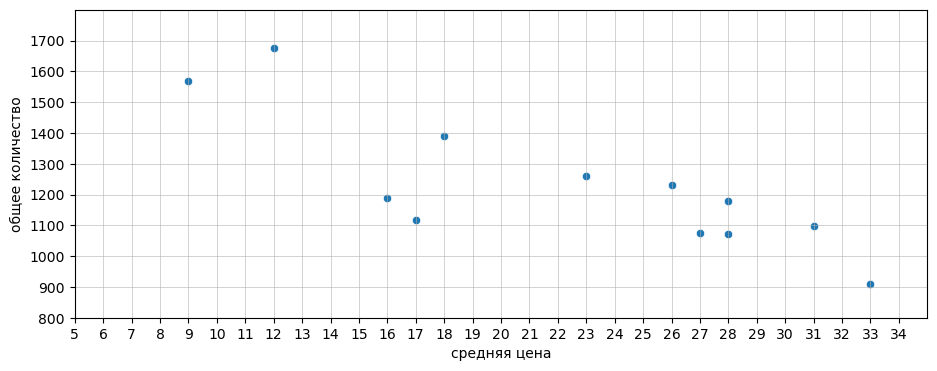

In [24]:
plt.figure(figsize=(11,4))

sns.scatterplot(x='X', y='Y', data=df)

plt.xlim([5,35])
plt.xticks(ticks=np.arange(5, 35))
plt.ylim([800,1800])
plt.yticks(ticks=np.arange(800, 1800, 100))
plt.xlabel('средняя цена')
plt.ylabel('общее количество')
plt.grid(linewidth=0.4);

Найдем уравнение $\hat{y} = a x^b$, где \
$a, b$ – постоянные коэффициенты, \
$x$ – статистические данные аргумента функции, \
$y$ - приближение значений функции к реальным данным полученным методом наименьших квадратов

In [25]:
popt, pcov = curve_fit(lambda x, a, b: a * x ** b, df['X'], df['Y'])
a = popt[0]
b = popt[1]
a, b

(3506.514997319852, -0.3477945722309196)

In [26]:
y_pred = a * df['X'] ** b

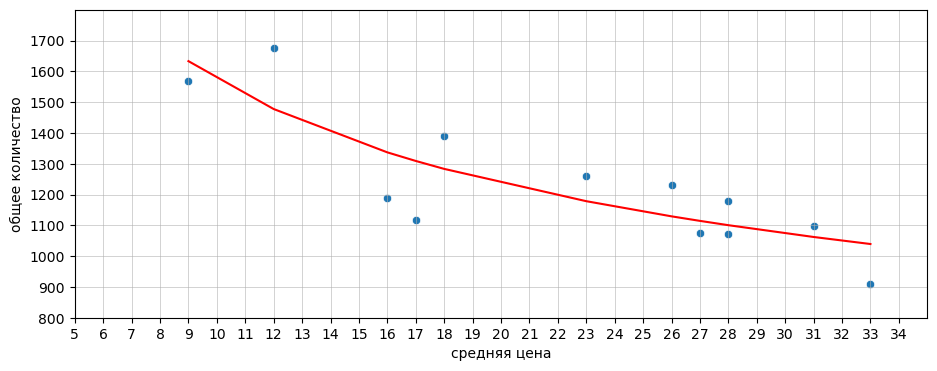

In [27]:
plt.figure(figsize=(11,4))

sns.scatterplot(x='X', y='Y', data=df)
sns.lineplot(x=df['X'], y=y_pred, color ='r')

plt.xlim([5,35])
plt.xticks(ticks=np.arange(5, 35))
plt.ylim([800,1800])
plt.yticks(ticks=np.arange(800, 1800, 100))
plt.xlabel('средняя цена')
plt.ylabel('общее количество')
plt.grid(linewidth=0.4);

In [28]:
My = df['Y'].mean()

# индекс детерминации
R2 = 1 - sum((df['Y'] - y_pred)**2) / sum((df['Y'] - My)**2)
R2

0.7021805866231943

Таким образом, в рамках построенной модели спрос на 70,2% зависит от изменения цены, а оставшаяся часть вариации (29,8%) спроса обусловлена факторами, не учтёнными моделью.

In [29]:
# индекс корреляции
R = np.sqrt(R2)
R

0.8379621630021217

Таким образом, существует сильная корреляционная зависимость количества проданных товаров от цены.

**Проверим статистическую значимость построенной модели.**

На уровне значимости $\alpha = 0.05$ \
проверим нулевую гипотезу $H_0: R_I^2 = 0$ – о том, что генеральный индекс детерминации равен нулю, \
против конкурирующей гипотезы $H_1: R_I^2 > 0$.

Для проверки гипотезы используем статистический критерий: \
$F = \cfrac{Q_R}{Q_e} \cdot \cfrac{n-m-1}{m}$, где \
$Q_R = \sum{(y(x_i)-\bar{y})^2}$ – выборочная факторная сумма квадратов, \
$Q_e = \sum(y_i - y(x_i))^2$ – выборочная остаточная сумма квадратов, \
$m$ – количество факторных (причинных) переменных.

Эта случайная величина имеет распределение Фишера (F-распределение) с количеством степеней свободы $k_1 = m$, $k_2 = n-m-1$.

Если $F_н > F_к$, то гипотезу $H_0$ на уровне значимости $\alpha$ отвергаем.\
Если $F_н < F_к$, то отвергать гипотезу $H_0$ оснований нет.

In [30]:
alpha = 0.05
m = 1
n = df.shape[0]
k1 = m
k2 = n-m-1

In [31]:
Fk = stats.f.ppf(1-alpha, k1, k2)
print(f'{Fk = }')

Fn = R2/(1-R2) * (n-m-1)/m
print(f'{Fn = }')

print(f'H0: R = 0 is {Fn<Fk}')

Fk = 4.9646027437307145
Fn = 23.577394725936976
H0: R = 0 is False


Полученный результат $R_I^2 = 0.702$ статистически значим, следовательно, статистически значимо и выборочное уравнение степенной регрессии:
$\hat{y} = 3506.5 x^{-0.35}$

In [32]:
# Средняя ошибка аппроксимации
A = sum(abs((df.Y-y_pred)/df.Y)) / n * 100
A

8.216747142526872

Таким образом, регрессионные значения $y(x_i)$ отличаются от соответствующих эмпирических значений $y_i$ в среднем на 8.2%, что является хорошим результатом.

***
## <font color = DarkGreen size = 5> <b>Параболическая регрессия</b> </font>

##### <font color = SlateBlue size = 3> Пример </font>

**По результатам выборочного исследования 10 хозяйств области получены следующие данные:**

| X | 1.4 | 2.62 | 2.89 | 2.11 | 1.64 | 1.97 | 2.46 | 2.76 | 1.87 | 2.27 |
|---|---|---|---|---|---|---|---|---|---|---|
| Y | 128 | 179 | 141 | 166 | 164 | 183 | 182 | 165 | 153 | 192 |

где, $X$ – количество внесённых минеральных удобрений на 1 гектар (центнеры),\
а $Y$ – соответствующая урожайность картофеля (ц/га – центнеров с га).

In [33]:
df = pd.DataFrame({'X': [1.4, 2.62, 2.89, 2.11, 1.64, 1.97, 2.46, 2.76, 1.87, 2.27],
                   'Y': [128, 179, 141, 166, 164, 183, 182, 165, 153, 192]})

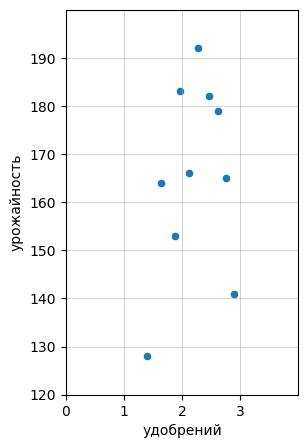

In [34]:
plt.figure(figsize=(3,5))

sns.scatterplot(x='X', y='Y', data=df)

plt.xlim([0,4])
plt.xticks(ticks=np.arange(0, 4))
plt.ylim([120,200])
plt.yticks(ticks=np.arange(120, 200, 10))
plt.xlabel('удобрений')
plt.ylabel('урожайность')
plt.grid(linewidth=0.4);

Найдем уравнение параболической регрессии $\hat{y} = ax^2 + bx + c$, где \
$a,b,c$ – постоянные коэффициенты, \
$x$ – статистические данные аргумента функции, \
$\hat{y}$ - приближение значений функции к реальным данным полученным методом наименьших квадратов

In [35]:
popt, pcov = curve_fit(lambda x, a, b, c: a*x**2 + b*x + c, df['X'], df['Y'])
a = popt[0]
b = popt[1]
c = popt[2]
a, b, c

(-76.22986552541212, 342.34519486846466, -202.41828655582182)

In [36]:
y_pred = a*df['X']**2 + b*df['X'] + c

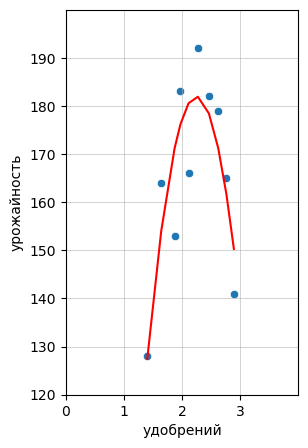

In [37]:
plt.figure(figsize=(3,5))

sns.scatterplot(x='X', y='Y', data=df)
sns.lineplot(x=df['X'], y=y_pred, color='r')

plt.xlim([0,4])
plt.xticks(ticks=np.arange(0, 4))
plt.ylim([120,200])
plt.yticks(ticks=np.arange(120, 200, 10))
plt.xlabel('удобрений')
plt.ylabel('урожайность')
plt.grid(linewidth=0.4);

In [38]:
My = df['Y'].mean()

# индекс детерминации
R2 = 1 - sum((df['Y'] - y_pred)**2) / sum((df['Y'] - My)**2)
R2

0.7350805218622477

Таким образом, в рамках построенной модели урожайность картофеля на 73,51%  зависит от количества внесённых удобрений. Оставшаяся часть вариации (26,49%) урожайности обусловлена другими факторами (составом почвы, погодой и т.д.).

In [39]:
# индекс корреляции
R = np.sqrt(R2)
R

0.8573683699917135

Зависимость урожайности от количества удобрений – сильная.

**Проверим статистическую значимость построенной модели.**

На уровне значимости $\alpha = 0.05$ \
проверим нулевую гипотезу $H_0: R_I^2 = 0$ – о том, что генеральный индекс детерминации равен нулю, \
против конкурирующей гипотезы $H_1: R_I^2 > 0$.

Для проверки гипотезы используем статистический критерий: \
$F = \cfrac{Q_R}{Q_e} \cdot \cfrac{n-m-1}{m}$, где \
$Q_R = \sum{(y(x_i)-\bar{y})^2}$ – выборочная факторная сумма квадратов, \
$Q_e = \sum(y_i - y(x_i))^2$ – выборочная остаточная сумма квадратов, \
$m$ – количество факторных (причинных) переменных.

Эта случайная величина имеет распределение Фишера (F-распределение) с количеством степеней свободы $k_1 = m$, $k_2 = n-m-1$.

Если $F_н > F_к$, то гипотезу $H_0$ на уровне значимости $\alpha$ отвергаем.\
Если $F_н < F_к$, то отвергать гипотезу $H_0$ оснований нет.

In [40]:
alpha = 0.05
m = 1
n = df.shape[0]
k1 = m
k2 = n-m-1

In [41]:
Fk = stats.f.ppf(1-alpha, k1, k2)
print(f'{Fk = }')

Fn = R2/(1-R2) * (n-m-1)/m
print(f'{Fn = }')

print(f'H0: R = 0 is {Fn<Fk}')

Fk = 5.317655071578714
Fn = 22.197855047261477
H0: R = 0 is False


Индекс детерминации $R_I^2 = 0.7351$ статистически значим, следовательно,  статистически значимо и выборочное уравнение параболической регрессии: $\hat{y} = -76.23 x^2 + 342.345 x - 202.42$

In [42]:
# Средняя ошибка аппроксимации
A = sum(abs((df.Y-y_pred)/df.Y)) / n * 100
A

5.100512147039381

Таким образом, эмпирически $y_i$ и соответствующие регрессионные значения $y(x_i)$ различаются в среднем на 5,1%, что можно признать очень хорошим результатом. 

С помощью уравнению регрессии определим оптимальное количество удобрений и соответствующую среднеожидаемую максимальную урожайность.

Найдём производную и приравняем её к нулю: \
$y' = (-76.23 x^2 + 342.345 x - 202.42)' = -76.23 \cdot 2x + 342.345 = -152.46 x + 342.345 = 0$

Оптимальному количеству удобрений соответствует корень этого уравнения:\
$x = \cfrac{342.345}{152.46} \approx 2.245$ центнеров на 1 га.

In [43]:
x = sp.Symbol('x')
y = (-76.23)*x**2 + 342.345*x - 202.42

# производная
yprime = y.diff(x)
yprime

342.345 - 152.46*x

In [44]:
# корни уровнения
ans = sp.solve(yprime, x)
ans

[2.24547422274695]

И, согласно полученному уравнению регрессии, этому значению соответствует среднеожидаемая максимальная урожайность:

In [45]:
f = sp.lambdify(x, y, 'math')
f(ans[0])

181.943436393152

Точка с координатами $(2.245; 181.94)$ – вершина параболы на чертеже. \
Следует заметить, что это среднеожидаемая оценка, полученная по конкретному уравнению регрессии.

***
## <font color = DarkGreen size = 5> <b>Логарифмическая регрессия</b> </font>

Найдем уравнение параболической регрессии $\hat{y} = a \ln x + b$, где \
$a,b$ – постоянные коэффициенты, \
$x$ – статистические данные аргумента функции, \
$\hat{y}$ - приближение значений функции к реальным данным полученным методом наименьших квадратов